In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

## CONSTANTS

# Define paths to excel files for reading data
DF_PATHS: list = ["../data/raw/ABSCHRIFTEN_20_Tagesbasis.xlsx",
                  "../data/raw/ABSCHRIFTEN_21_Tagesbasis.xlsx",
                  "../data/raw/ABSCHRIFTEN_22_Tagesbasis.xlsx"]

# Load Data

In [49]:
def clean_dataframe(path: str) -> pd.DataFrame:
    """
    Cleans data with some hardcoded rules.
    TBD: Change if data set are more clean / Talk to supervisors?

    :param path: str -- Path to excel file
    :return: pd.DataFrame -- Cleaned DataFrame
    """
    # Read in Data
    df = pd.read_excel(path)

    # Replace NaNs with 0
    df = df.replace({np.nan: 0})
    # Drop first column and other irrelevant rows
    df = df.drop(index=[0,1])
    # Drop aggregations
    df = df.drop(df.columns[2:4], axis=1)
    column_names = list(df.iloc[0, :])
    df.columns = column_names

    # Get GTIN as ID, remove first two entries
    GTIN = df.iloc[1, :]
    GTIN = GTIN[2:]
    GTIN = list(GTIN)
    GTIN.insert(0, "")

    # Keep only 'BACKWAREN BED' samples and drop the column then
    df = df[df.iloc[:,0] == "BACKWAREN BED"]
    df = df.iloc[:, 1:]
    # Rename time column
    df.rename(columns={df.columns[0]: "date" }, inplace = True)
    # Remove 'Ergebnis' row
    df = df[df["date"] != "Ergebnis"]

    # Reset index
    df = df.reset_index(drop=True)

    # Add GTIN to Names
    df.columns = [col + f"{gtin}" for col, gtin in zip(df.columns, GTIN)]

    # Put features in right data type
    df["date"] = pd.to_datetime(df["date"], dayfirst="True")

    numerical_columns = [col for col in df.columns if col != "date" ]
    df[numerical_columns] = df[numerical_columns].astype(np.float32)

    return df

# Initialize empty list to populate with processed dataframes (Abschriften)
abschriften: list[pd.DataFrame] = []
for path in DF_PATHS:
    abschriften_df = clean_dataframe(path)
    abschriften.append(abschriften_df)

# Preview df
df = abschriften[1] # ABSCHRIFTEN 2021
df

,date,MBK TEE NORMAL25004816,CAPPUCINO2064200170893,MBK QUARK-BUSSY 1 STUECK25006940,MBK MILCHKAFFEE KLEIN25007381,MBK VESPERBROTGEMUESEVARIATION25009743,MBK VESPERBR. GEMUESEVAR. HALB25010633,BAK MINI-SCHNECKEN NUSS25012071,BAK MINI-SCHNECKEN QUARK25012088,BAK MINI-SCHNECKEN MOHN25012095,...,MBK METERKUCH.WIN.BIRNE CA.1KG25033816,LAUGENKNOTEN 72G179014,MBK MINI LAUG.PIZZA MARGHERITA179022,MBK MINI LAUG.PIZZA FLAMMENK.179023,MBK MINI LAUG.PIZZA SALAMI179024,MBK MINI LAUG.PIZZA SCHINKEN179025,MBK MINI PIZZA FLAMMENKUCHEN179027,MBK MINI PIZZA SALAMI179028,MBK MINI PIZZA SCHINKEN179029,BAK QUICHE A LA LORRAINE 160G4314131016691
0,2021-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2021-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,2021-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,2021-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
def get_top_k_foodwasting_products(df: pd.DataFrame, k: int = 5) -> pd.Series:
    """ Returns pd.Series having the product name as key and aggregated sum as values

    First selects only numerical features / products.
    Then sums over all timesteps and sorts the Series ascending.
    Sorted pd.Series is then sliced (first k entries) and returned

    :param df: pd.DataFrame -- Cleaned dataframe
    :param k: int -- Top k foodwasting products
    :return: pd.Series -- Top k foodwasting products (key) and values
    """
    # Get only numerical cols
    numerical_cols = df.select_dtypes(include='number').columns
    # Aggregate over rows / timesteps and sort ascending
    sums_aggregated = df[numerical_cols].sum().sort_values(ascending=True)

    return sums_aggregated[:k]

K: int = 5
top_k_foodwasting_products = get_top_k_foodwasting_products(df, k = K)
top_k_foodwasting_products

BAK GRUENDERBROT 750G4314131013126           -1999.100098
BAK LAUGENBREZEL4314131001529                -1453.699951
BAK GRUENDERBROT ROGGEN 750G4314131013096    -1400.300049
BAK BROET/KNUSPERW.TEIGL. 57G4314131001888   -1333.050049
BAK URKULTURKORN BROT 750G4314131012983      -1308.090088
dtype: float32

# Plot Top k Foodwasting Products

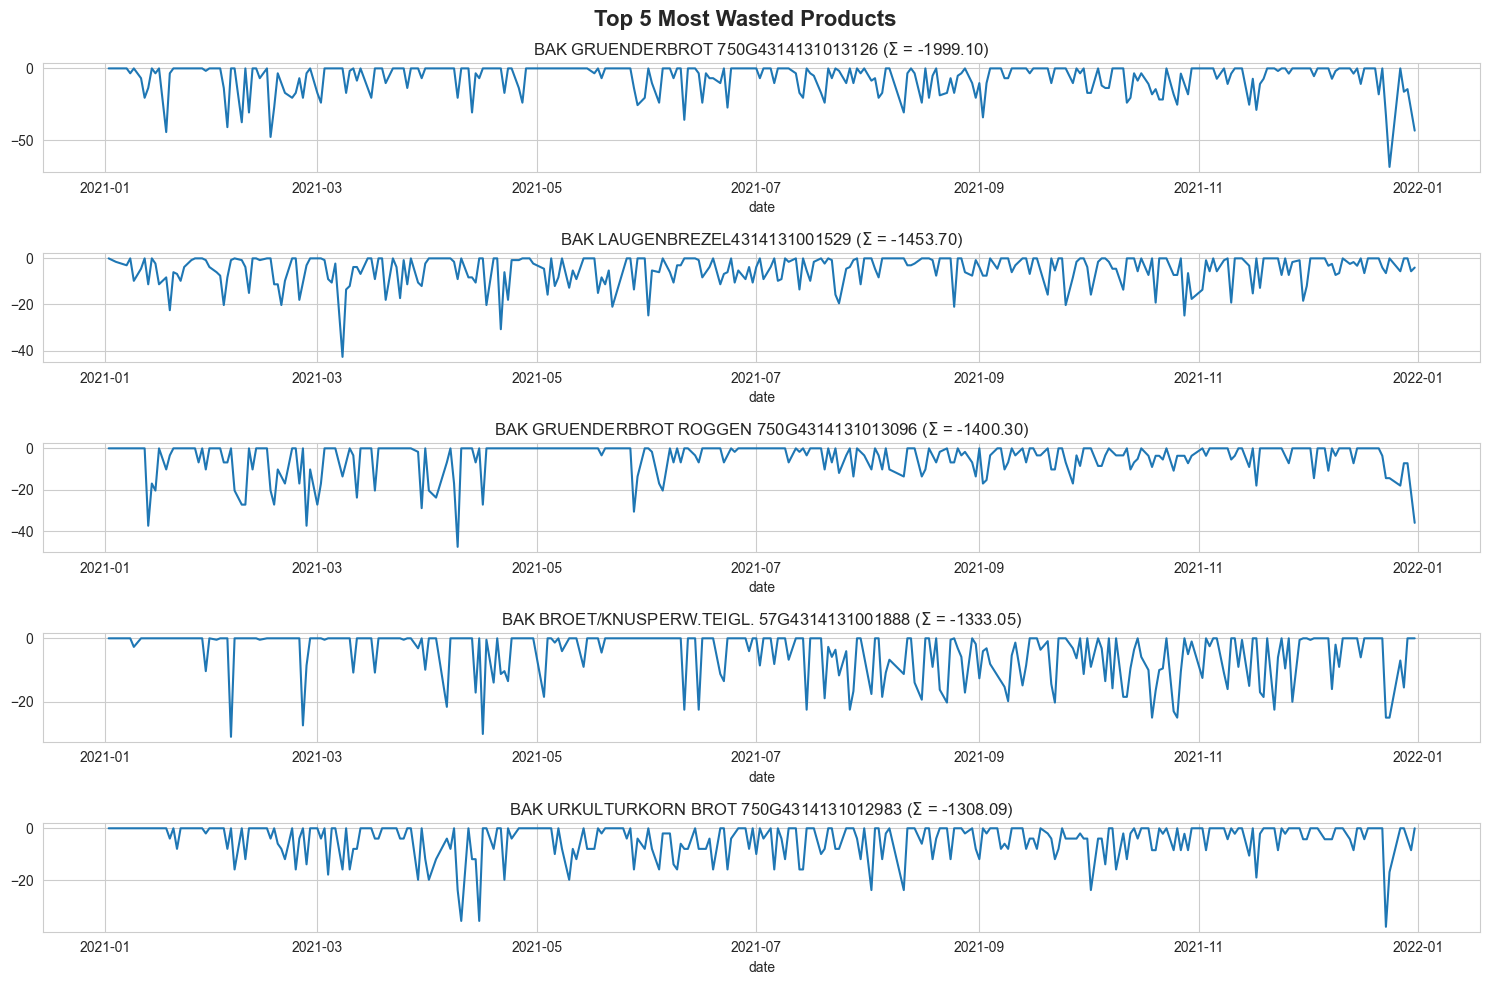

In [107]:
fig, axes = plt.subplots(nrows=K, ncols=1, figsize=(15, K*2))
fig.suptitle(f"Top {K} Most Wasted Products", fontweight="bold", size=16)
for ax, col in zip(axes.flatten(), top_k_foodwasting_products.keys()):
    # Set title and also get sum of wasted revenue over the time frame
    ax.set_title(f"{col} ($\Sigma$ = {top_k_foodwasting_products[col]:.2f})", size=12)
    sns.lineplot(data=df, x="date", y=col, ax=ax)
    # Hide y-axis labels
    ax.yaxis.label.set_visible(False)
fig.tight_layout()
plt.show()

# Modelling

In [58]:
# Sample dataframe
top_foodwasting_product_name:str = top_k_foodwasting_products.keys()[0]
# Preview one sample
gruenderbrot_df = df[["date", top_foodwasting_product_name]]
gruenderbrot_df.head(5)

,date,BAK GRUENDERBROT 750G4314131013126
0,2021-01-02,0.0
1,2021-01-04,0.0
2,2021-01-07,0.0
3,2021-01-08,-3.4
4,2021-01-09,0.0


In [93]:
def train_test_split(df: pd.DataFrame, last_k_percent: float = 0.1):

    # Get total number of samples
    N = len(df)
    # Get last k percent as absolute value
    k = int(N * last_k_percent)

    # Get first N-k values, e.g. first 250 values
    X_train = df.iloc[:(N-k), :]
    # Get last k values, e.g. last 50 values
    X_test = df.iloc[-k:, :]

    return X_train, X_test

X_train, X_test = train_test_split(gruenderbrot_df, last_k_percent=0.2)

In [94]:
X_train

,date,BAK GRUENDERBROT 750G4314131013126
0,2021-01-02,0.0
1,2021-01-04,0.0
2,2021-01-07,0.0
3,2021-01-08,-3.4
4,2021-01-09,0.0
...,...,...
235,2021-10-15,-8.5
236,2021-10-16,-3.4
237,2021-10-18,-10.8
238,2021-10-19,-18.0
